<a href="https://colab.research.google.com/github/YoishD/Data-Science-B7/blob/main/YeshDakpU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Magic the Gathering is a deck building game, where you build of 99 cards, comprised of spells and lands in order to lower your opponents life total to zero. Every spell has an innate cost to them, one that you pay with mana. You generate mana either through lands, and each land gives you one mana, or through spells that generate mana.In general, you want to atleast play one land per turn.
 Within the metagame, their are already standard deck building convention(sbdc) that one should aim to meet:Its is recommended that for a deck having an average mana cost of 3 (the typical average mana cost for decks),to have 41 lands, minus every 3 mana generation spell.

Is the pre-existing sbdc, without any mana generation spells for a total of 41/99 lands, an adequate model to build a deck that is able place one land per turn, by comparing the percentages of having 4 mana by turn 4 to the percentanges of having 3,2,1 mana by turn 4.




In [1]:
!pip install "preliz[full,notebook]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.1

In [2]:
import preliz as pz


In [3]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
import pandas as pd

In [4]:
data_manaturn = pd.read_csv('https://raw.githubusercontent.com/YoishD/Data-Science-B7/refs/heads/main/AVG.csv')
data_manaturn

,4
0,4
1,4
2,4
3,1
4,3
5,4
6,4
7,4
8,3
9,3


(array([ 3.,  0.,  7.,  0.,  0.,  9.,  0., 12.,  0., 16.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

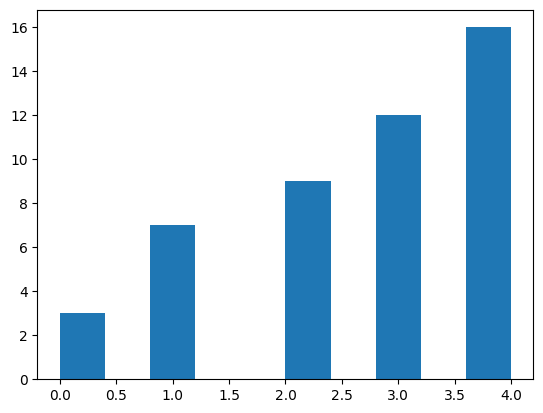

In [ ]:
plt.hist(data_manaturn)

I will that just looking at this, we kind of already have our answer, and that our standard deck builiding conventions have some merit as we can clearly see that the times we have 4 mana more than any other occurence. But still, lets try to find a distribution that fits the data.

In [ ]:
with pm.Model() as model_manaturnN:
    # our Mean should be between 3 and 4, just by glancing at the data we see a very clear left skew
    μ = pm.Uniform('μ', lower=3, upper=4)

    #this one is new, but its exactly what it sounds like: half of a normal dist
    σ = pm.HalfNormal('σ', sigma=5)

    #our fancy new likelihood, with two priors
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=data_manaturn)
    idata_manaturnN = pm.sample()

Output()

Output()

No divergences, but I still feel like the numbers generated from the distributions are quite small (specifically sigma), so I am going to try and find other distributions to work with. Also know that the reason why I started with this distribution is that I wanted to just use what Mr.A used from the notes just to get a hand on things.

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

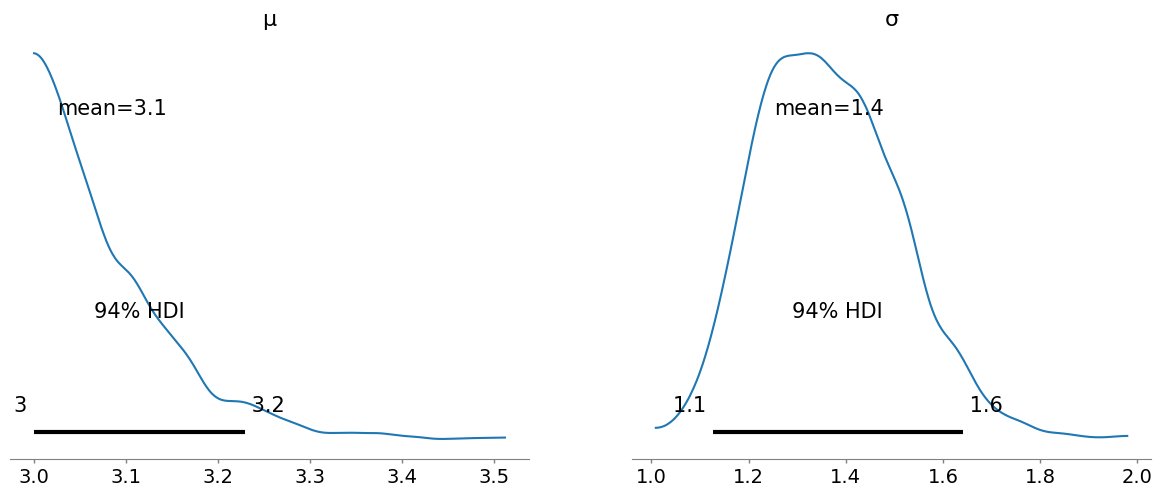

In [ ]:
az.plot_posterior(idata_manaturnN)

array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

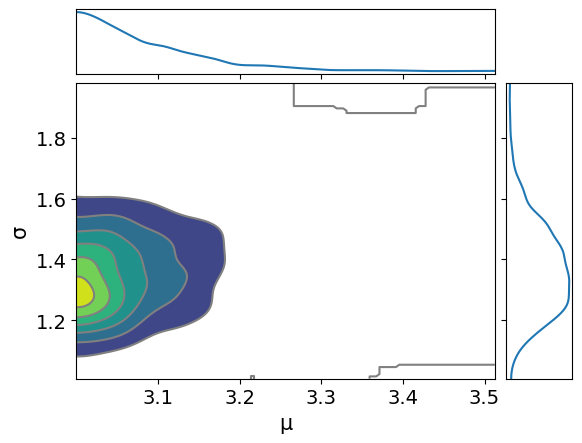

In [ ]:
az.plot_pair(idata_manaturnN, kind='kde', marginals=True)

In [ ]:
pm.sample_posterior_predictive(idata_manaturnN, model=model_manaturnN, extend_inferencedata=True)


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

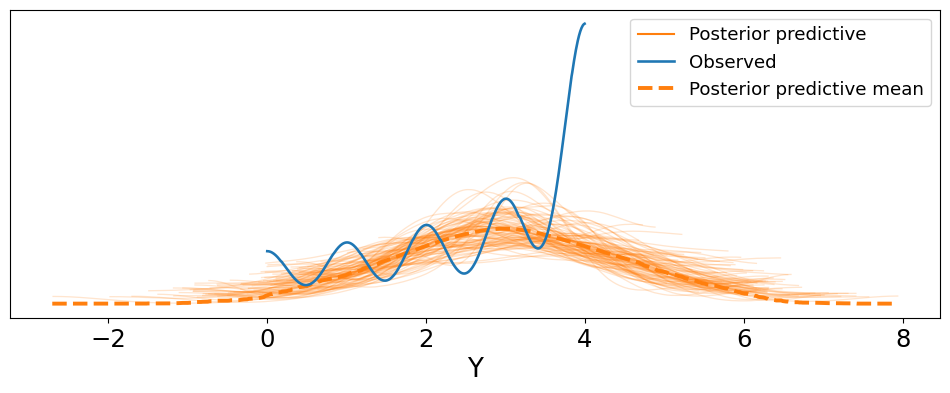

In [ ]:
az.plot_ppc(idata_manaturnN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

PPC does not match with our observed so lets choose a new prior. I recgonize that I am only dealing with positive discrete numbers, and the histogram showcased a left skew, so for our new likelihood, I'll try to find one that is inline with those parameters.

In [ ]:
with pm.Model() as model_manaturnN:
#changed the paramenters because I overestmiated the mean originally.
    μ = pm.Uniform('μ', lower=2, upper=4)

    Y = pm.Poisson('Y',mu=μ,observed=data_manaturn)
    idata_manaturnN = pm.sample()

Output()

Output()

<Axes: title={'center': 'μ'}>

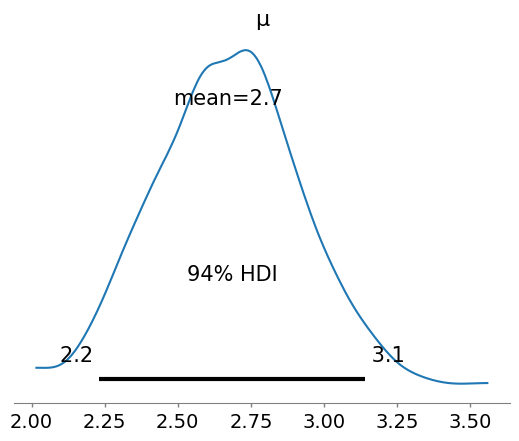

In [ ]:
az.plot_posterior(idata_manaturnN)

In [ ]:
pm.sample_posterior_predictive(idata_manaturnN, model=model_manaturnN, extend_inferencedata=True)


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

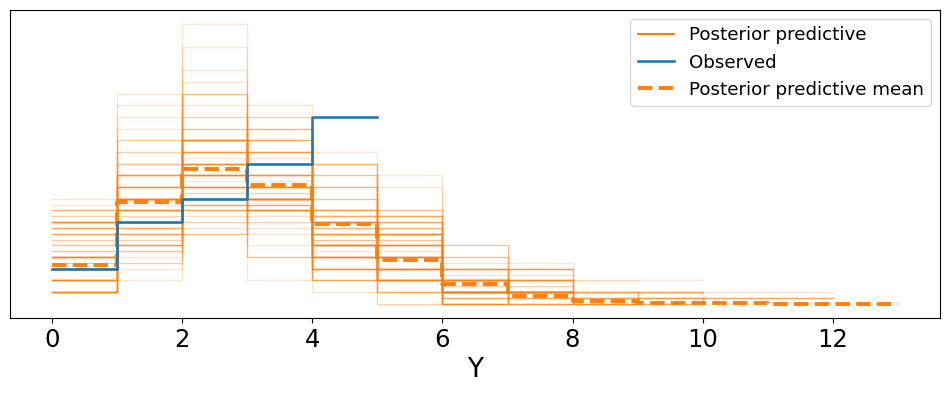

In [ ]:
az.plot_ppc(idata_manaturnN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Its kind of right? Up until x=3, our slopes are pretty similar (atleast they go in the same direction). The problem is I am struggling to find a distribution that is both discrete and left skew. If I just use a left skew distribution, my observed will look like a sine graph again, and If I use a discrete, I can't find a left skew for it. Maybe I could still use the Poisson Graph, however I would need to limit it to x=4, since in the situation describe, we are not able to have more than 5 mana by turn 4. I am going to try messing with mu, more and trying to get it to fit.

In [16]:
with pm.Model() as model_manaturnN:
    μ = pm.Cauchy('μ', alpha=4, beta=1)
        # Alpha is representitve of our mode

    Y = pm.Poisson('Y',mu=μ,observed=data_manaturn)
    idata_manaturnN = pm.sample()

Output()

Output()

<Axes: title={'center': 'μ'}>

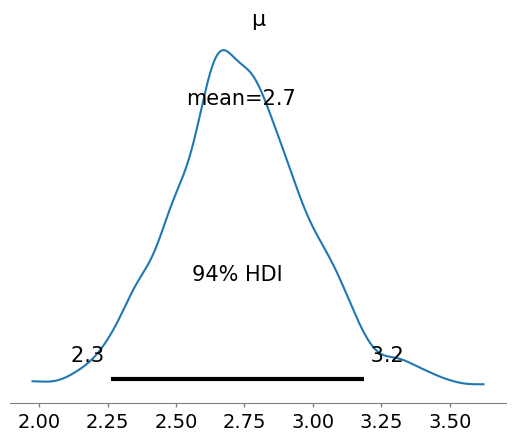

In [17]:
az.plot_posterior(idata_manaturnN)

In [18]:
pm.sample_posterior_predictive(idata_manaturnN, model=model_manaturnN, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

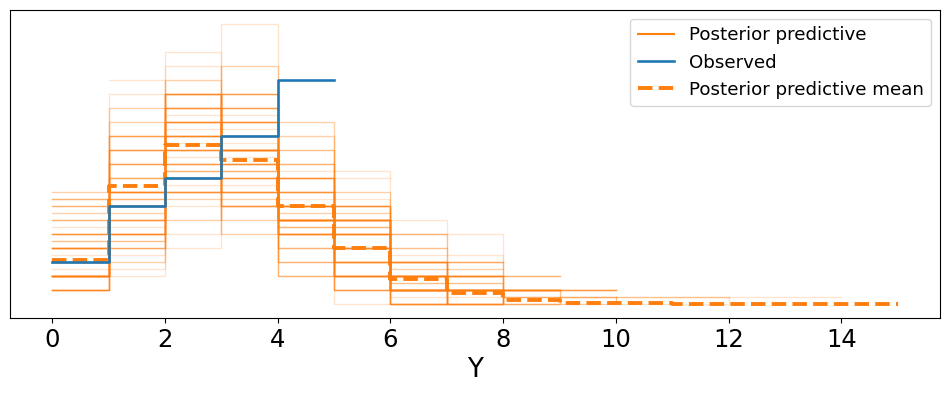

In [19]:
az.plot_ppc(idata_manaturnN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

NOOOO ITS SO CLOSE!! Okay so I think I am on the right track, I just need to nail down my parameters.

In [ ]:
with pm.Model() as model_manaturnN:
    μ = pm.Weibull('μ', alpha=16, beta=4)
      #In order to make a left skew for weibull, alpha>beta, so i just switched them around in order to be representative of our histogram

    Y = pm.Poisson('Y',mu=μ,observed=data_manaturn)
    idata_manaturnN = pm.sample()

Output()

Output()

<Axes: title={'center': 'μ'}>

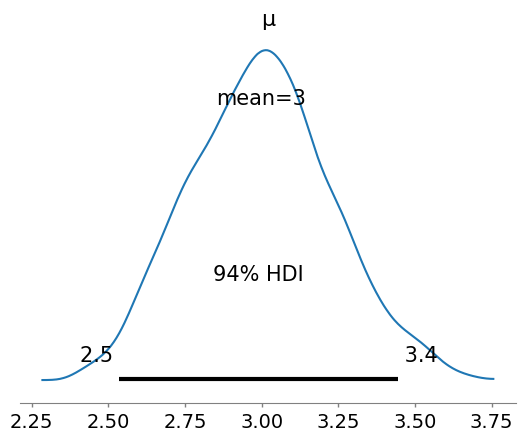

In [ ]:
az.plot_posterior(idata_manaturnN)

In [ ]:
pm.sample_posterior_predictive(idata_manaturnN, model=model_manaturnN, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

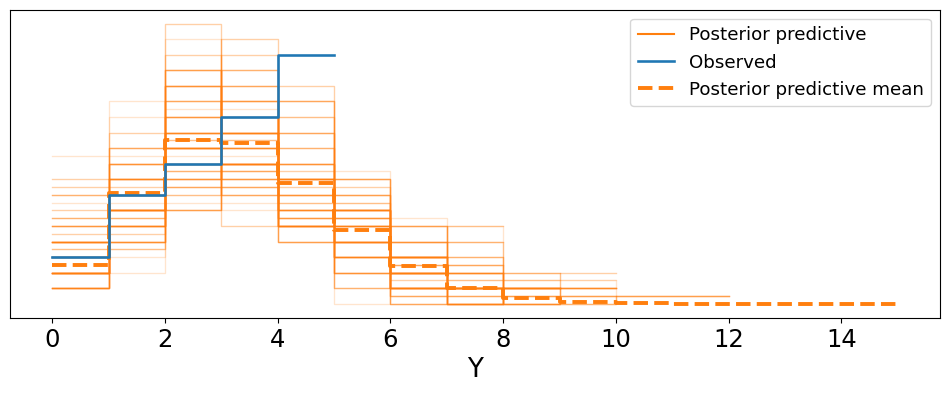

In [ ]:
az.plot_ppc(idata_manaturnN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

I think at this point I just need to choose a different likelihood.Under the advice of Mr.A, I am switching to an Asymmetric lapace. Since my model is based off a game,I actually know all factors already and this serves more as a toy model than anything,so I should worry more on about actually matching my data than anything. Also this distribution will keep on continuing past its maximum, something I do not want, as our observed has a max and stops at x=4, so I would have needed to change my distribution anyways

In [11]:
with pm.Model() as model_manaturnN:
    μ = pm.Gumbel('μ', mu=4, beta=1)
        #Based off my earlier guess for mu
    b = pm.Uniform('b',upper=4,lower=3.8)
        #After messing around with Asym.Lapace I found some parameters that would fit, and I am using Uniform Dist. to kind of create a range of parameters that works.
          #This is the scale parameter, since I want my graph to be really high near the end I want this really large
    q = pm.SkewNormal('q',mu=0.5,sigma=1,alpha=4)
        #I repeated my steps for my B parameters and just messed around with Asym. Lapace to find some numbers that would fit
          #This is our scale parameter, so I want it to be close to 1, so we have a left skew
    Y = pm.AsymmetricLaplace('Y',mu=μ,b=b,q=q,observed=data_manaturn)
      # I struggled alot with what distributions to use for my parameters
    idata_manaturnN = pm.sample()

/usr/local/lib/python3.10/dist-packages/pytensor/tensor/math.py:893: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/math.py:893: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/math.py:893: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/math.py:893: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/math.py:893: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/math.py:893: FutureWarning: sgn is deprecated and will stop working in the

Output()

Output()

array([<Axes: title={'center': 'b'}>, <Axes: title={'center': 'q'}>,
       <Axes: title={'center': 'μ'}>], dtype=object)

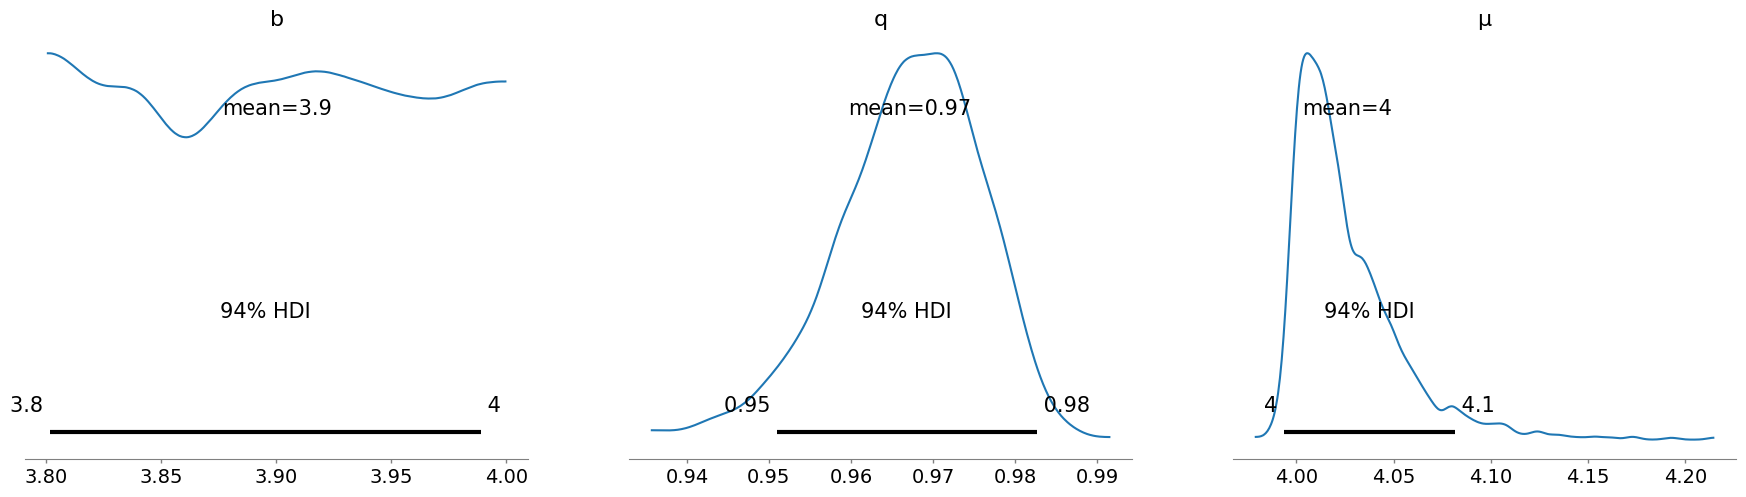

In [12]:
az.plot_posterior(idata_manaturnN)

In [13]:
pm.sample_posterior_predictive(idata_manaturnN, model=model_manaturnN, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

array([[<Axes: ylabel='b'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='q'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='b', ylabel='μ'>, <Axes: xlabel='q'>,
        <Axes: xlabel='μ'>]], dtype=object)

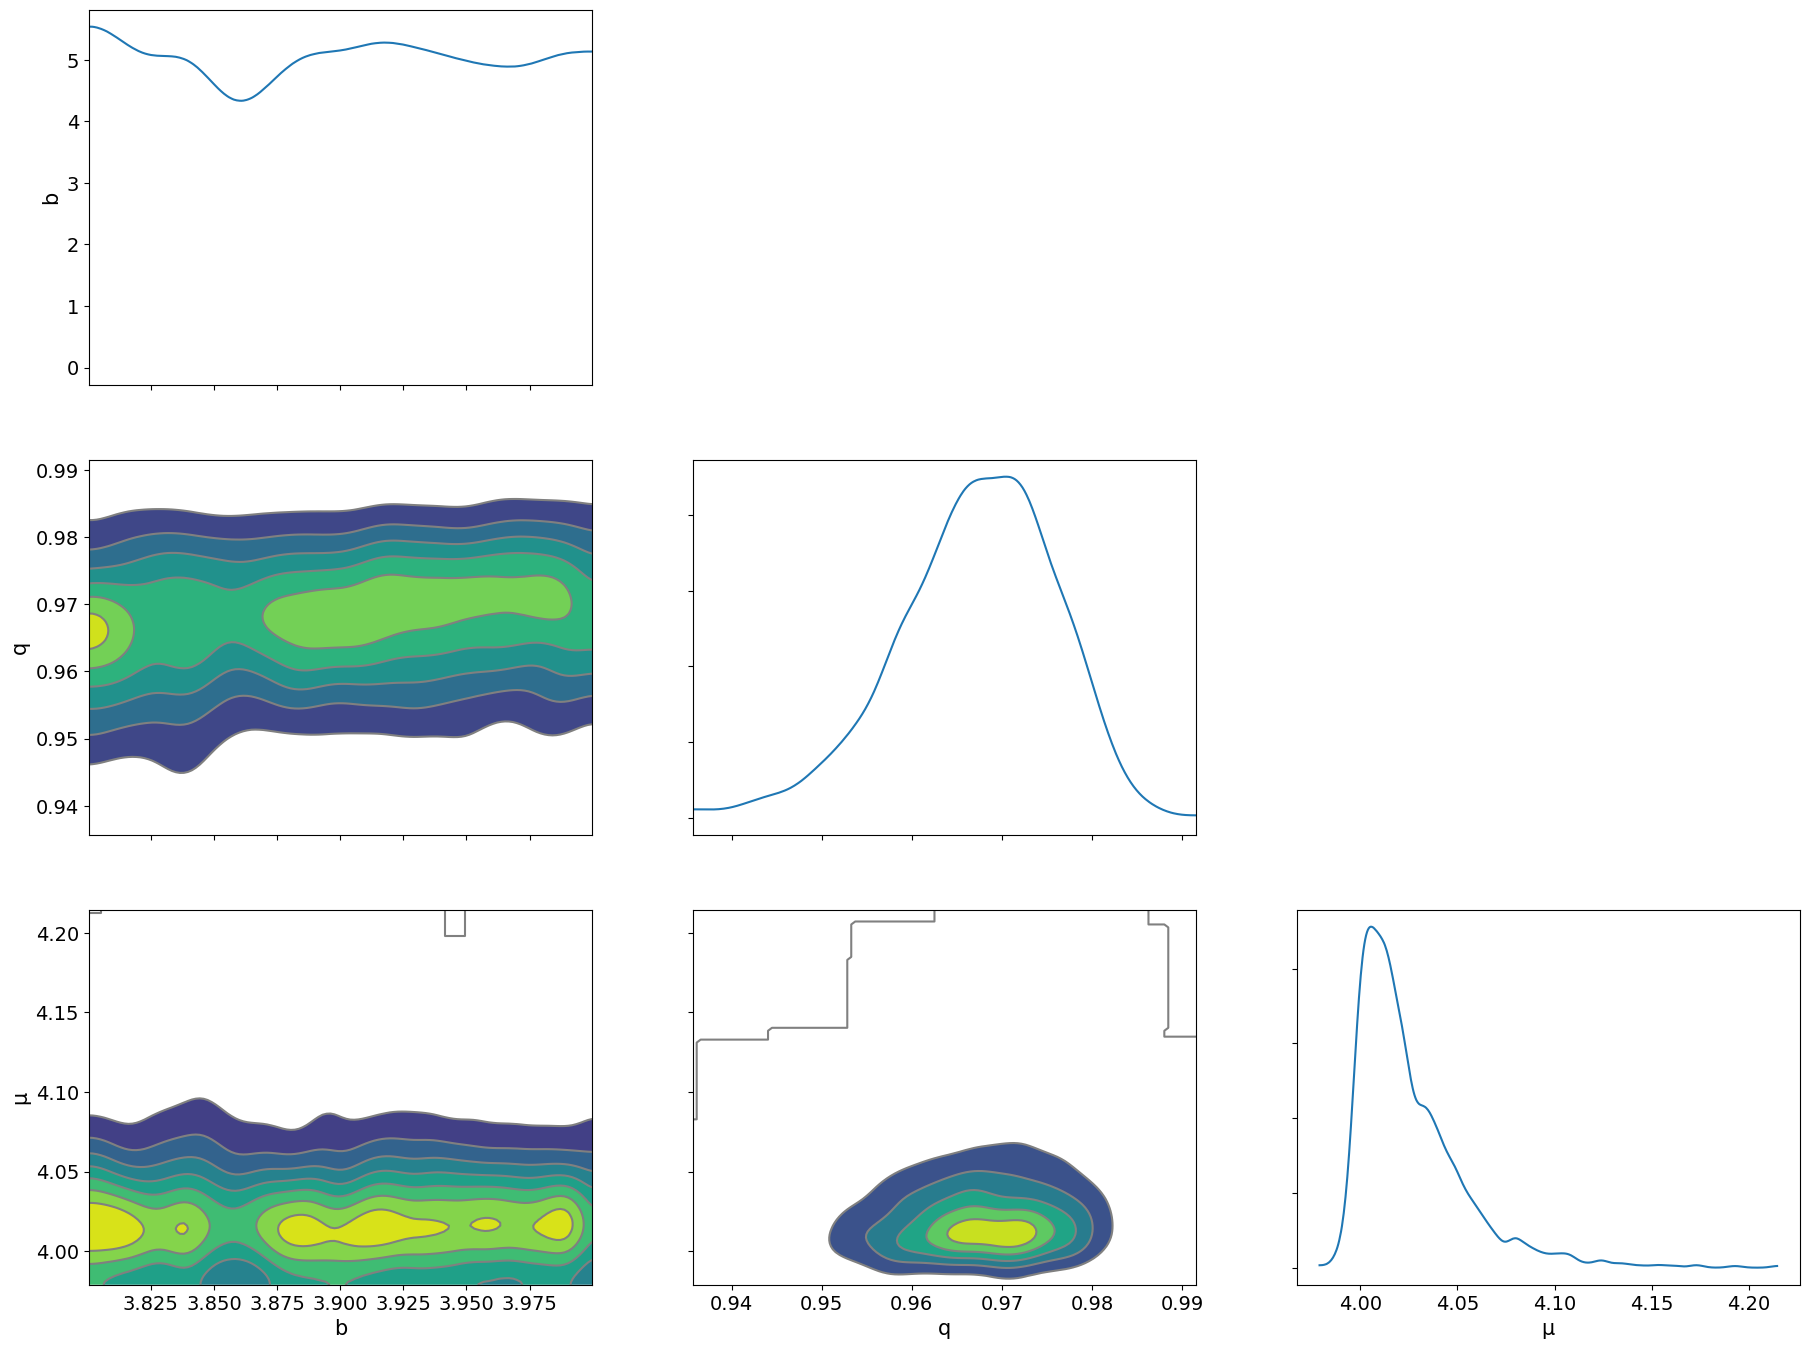

In [14]:
az.plot_pair(idata_manaturnN, kind='kde', marginals=True)

<Axes: xlabel='Y'>

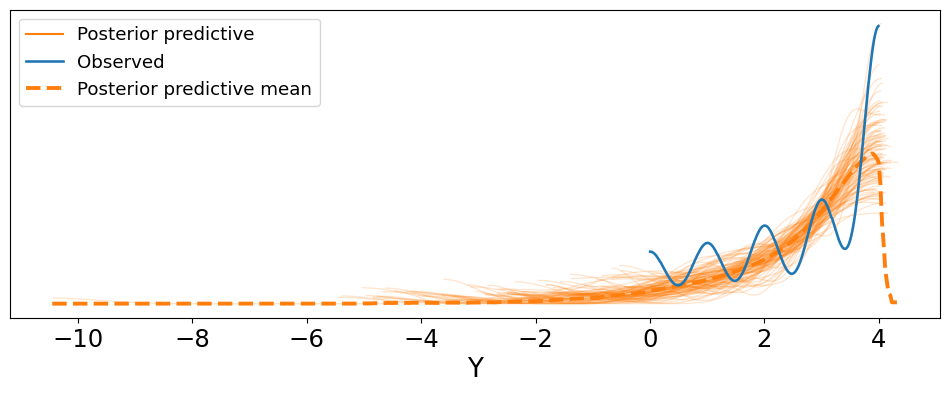

In [15]:
az.plot_ppc(idata_manaturnN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

It is so close, I have the form correct, it's just that it isn't the same magnitude. Most likely I require a completly different likelihood that I just don't know. My best guess for why is because, I can't have a value more than 4 no matter what , which is something I don't really know how to account for with the distributions I know. This x=4 limiter, is a reference to how you are not able to place more than one land per turn, and meeerly a factor of the game itself. Maybe if I were to have chosen a differently problem, such as asking the percentages of drawing x lands by turn 4, then I could forgo the asymptote, and actually have an accurate distribution to use.

I actually did find a couple of nice distributions that would have worked if not for the fact that I was limited to x=4. For example, My Poisson distribtion is actually pretty spot on, aside from how it keeps on continuing past x=4.

However, I can see that it does seem just looking from the general trend of the observed and the PPM(even though it doesn't really match our data) that, yes, standard deck builiding conventions(sbdc) are correct in that using sbdc, by turn 4, you have a higher chance of more mana than less.
